In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [2]:
import logging
import string
import sys
import os
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from src.figure_utilities import (
    PAGE_HEIGHT,
    ONE_COLUMN,
    TWO_COLUMN,
    save_figure,
    set_figure_defaults,
)

set_figure_defaults()

In [3]:
from glob import glob
import os
import pandas as pd
from src.parameters import PROCESSED_DATA_DIR, STATE_COLORS, STATE_ORDER
from src.figure_utilities import TWO_COLUMN, PAGE_HEIGHT, save_figure
import seaborn as sns
import matplotlib.pyplot as plt
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_linear_position_markers,
)

from loren_frank_data_processing import make_tetrode_dataframe
from src.parameters import ANIMALS, STATE_ORDER, _BRAIN_AREAS

tetrode_info = make_tetrode_dataframe(ANIMALS)

data_type, dim = "clusterless", "1D"
n_unique_spiking = 2

file_paths = glob(
    os.path.join(
        PROCESSED_DATA_DIR, f"*_{data_type}_{dim}_no_interneuron_replay_info_80.csv"
    )
)


def read_file(file_path):
    try:
        return pd.read_csv(file_path)
    except pd.errors.EmptyDataError:
        pass


replay_info = pd.concat(
    [read_file(file_path) for file_path in file_paths], axis=0,
).set_index(["animal", "day", "epoch", "ripple_number"])
replay_info = replay_info.loc[
    replay_info.n_unique_spiking >= n_unique_spiking
].sort_index()

is_brain_areas = tetrode_info.area.astype(str).str.upper().isin(_BRAIN_AREAS)
n_tetrodes = (
    tetrode_info.loc[is_brain_areas]
    .groupby(["animal", "day", "epoch"])
    .tetrode_id.count()
    .rename("n_tetrodes")
)
replay_info = pd.merge(
    replay_info.reset_index(), pd.DataFrame(n_tetrodes).reset_index()
).set_index(["animal", "day", "epoch", "ripple_number"])

for state in STATE_ORDER:
    replay_info[f"{state}_pct_unique_spiking"] = (
        replay_info[f"{state}_n_unique_spiking"] / replay_info["n_tetrodes"]
    )
replay_info = replay_info.rename(index={"Cor": "cor"}).rename_axis(
    index={"animal": "Animal ID"}
)
replay_info.head()

Continuous  Continuous_Cont_avg_prob  \
Animal ID day epoch ripple_number                                         
cor       1   2     1                   False                       NaN   
                    2                   False                       NaN   
                    3                   False                       NaN   
                    4                    True                  0.877059   
                    5                   False                       NaN   

                                   Continuous_Frag_avg_prob  \
Animal ID day epoch ripple_number                             
cor       1   2     1                                   NaN   
                    2                                   NaN   
                    3                                   NaN   
                    4                              0.019443   
                    5                                   NaN   

                                   Continuous_Hov_avg_prob  \
Animal ID day epoch ripple_number                            
cor       1   2     1                                  NaN   
                    2                                  NaN   
                    3                                  NaN   
                    4                             0.103498   
                    5                                  NaN   

                                   Continuous_duration  \
Animal ID day epoch ripple_number                        
cor       1   2     1                            0.000   
                    2                            0.000   
                    3                            0.000   
                    4                            0.054   
                    5                            0.000   

                                   Continuous_fraction_of_time  \
Animal ID day epoch ripple_number                                
cor       1   2     1                                 0.000000   
                    2                                 0.000000   
                    3                                 0.000000   
                    4                                 0.613636   
                    5                                 0.000000   

                                   Continuous_max_probability  \
Animal ID day epoch ripple_number                               
cor       1   2     1                                0.291176   
                    2                                0.295254   
                    3                                0.331807   
                    4                                0.906420   
                    5                                0.442057   

                                   Continuous_max_ripple_consensus_trace_zscore  \
Animal ID day epoch ripple_number                                                 
cor       1   2     1                                                       NaN   
                    2                                                       NaN   
                    3                                                       NaN   
                    4                                                 11.407677   
                    5                                                       NaN   

                                   Continuous_max_time  \
Animal ID day epoch ripple_number                        
cor       1   2     1                              NaN   
                    2                              NaN   
                    3                              NaN   
                    4                            0.056   
                    5                              NaN   

                                   Continuous_mean_ripple_consensus_trace_zscore  \
Animal ID day epoch ripple_number                                                  
cor       1   2     1                                                        NaN   
                    2                                            

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10')]

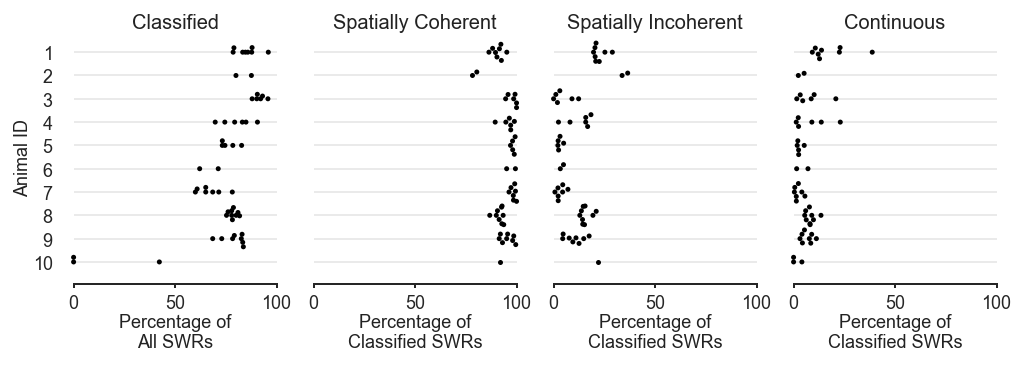

In [4]:
fig, axes = plt.subplots(
    1,
    4,
    figsize=(TWO_COLUMN, PAGE_HEIGHT / 4),
    sharex=True,
    sharey=True,
    constrained_layout=True,
)

dot_color = "black"
dot_size = 2.5

# ax 0
df = pd.DataFrame(
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["is_classified"]).mean() * 100)
    .rename("Percentage of All SWRs")
).reset_index()

sns.swarmplot(
    data=df,
    x="Percentage of All SWRs",
    y="Animal ID",
    ax=axes[0],
    size=dot_size,
    color=dot_color,
    clip_on=False,
)
axes[0].set_title("Classified", fontsize=10)
axes[0].grid(True, axis="y", linestyle="-", alpha=0.5)
axes[0].set_xlabel("Percentage of\nAll SWRs")

# ax 1
df = pd.DataFrame(
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(
        lambda df: (df["Hover"] | df["Hover-Continuous-Mix"] | df["Continuous"]).mean()
        * 100
    )
    .rename("Percentage of Classified SWRs")
).reset_index()
sns.swarmplot(
    data=df,
    x="Percentage of Classified SWRs",
    y="Animal ID",
    ax=axes[1],
    size=dot_size,
    color=dot_color,
    clip_on=False,
)
axes[1].set_ylabel("")
axes[1].set_xlabel("Percentage of\nClassified SWRs")
axes[1].set_title("Spatially Coherent", fontsize=10)
axes[1].grid(True, axis="y", linestyle="-", alpha=0.5)

# ax 2
df = pd.DataFrame(
    replay_info.loc[replay_info.is_classified]
    .groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Fragmented-Continuous-Mix"] | df["Fragmented"]).mean() * 100)
    .rename("Percentage of Classified SWRs")
).reset_index()
sns.swarmplot(
    data=df,
    x="Percentage of Classified SWRs",
    y="Animal ID",
    ax=axes[2],
    size=dot_size,
    color=dot_color,
    clip_on=False,
)
axes[2].set_ylabel("")
axes[2].set_xlabel("Percentage of\nClassified SWRs")
axes[2].set_title("Spatially Incoherent", fontsize=10)
axes[2].grid(True, axis="y", linestyle="-", alpha=0.5)

# ax 3
df = pd.DataFrame(
    replay_info.groupby(["Animal ID", "day"])
    .apply(lambda df: (df["Continuous"]).mean() * 100)
    .rename("Percentage of Classified SWRs")
).reset_index()

sns.swarmplot(
    data=df,
    x="Percentage of Classified SWRs",
    y="Animal ID",
    ax=axes[3],
    size=dot_size,
    color=dot_color,
    clip_on=False,
)

axes[3].set_xlabel("Percentage of\nClassified SWRs")
axes[3].set_ylabel("")
axes[3].set_title("Continuous", fontsize=10)
axes[3].grid(True, axis="y", linestyle="-", alpha=0.5)
plt.xlim((0, 100))
sns.despine(offset=5)
for ind in range(0, 4):
    axes[ind].spines["left"].set_visible(False)
    axes[ind].tick_params(left=False)
n_animals = replay_info.reset_index()["Animal ID"].unique().size
axes[0].set_yticklabels(np.arange(n_animals) + 1)

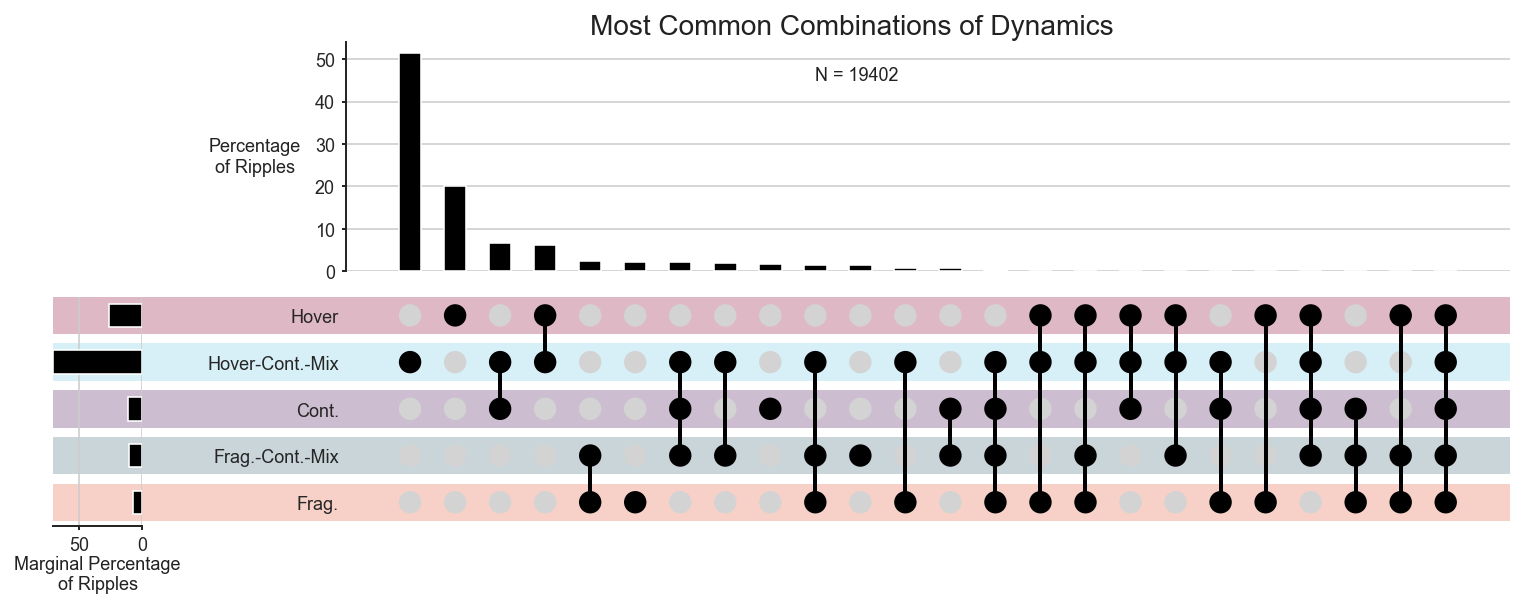

In [5]:
from src.visualization import SHORT_STATE_NAMES
from src.parameters import SHORT_STATE_ORDER, STATE_ORDER
from upsetplot import UpSet


def plot_category_counts(replay_info):
    df = replay_info.rename(columns=SHORT_STATE_NAMES).set_index(
        SHORT_STATE_ORDER[::-1]
    )
    upset = UpSet(
        df,
        sort_sets_by=None,
        show_counts=False,
        subset_size="count",
        sort_by="cardinality",
        intersection_plot_elements=5,
    )
    ax_dict = upset.plot()
    n_classified = replay_info.is_classified.sum()
    _, intersect_max = ax_dict["intersections"].get_ylim()
    ax_dict["intersections"].set_yticks(n_classified * np.arange(0, 0.6, 0.1))
    ax_dict["intersections"].set_yticklabels(range(0, 60, 10))
    ax_dict["intersections"].set_ylabel(
        "Percentage\nof Ripples",
        ha="center",
        va="center",
        rotation="horizontal",
        labelpad=30,
    )
    ax_dict["intersections"].text(
        9, n_classified * 0.45, f"N = {n_classified}", zorder=1000, fontsize=9
    )

    ax_dict["totals"].set_xticks([0, 0.5 * n_classified])
    ax_dict["totals"].set_xticklabels([0, 50])
    ax_dict["totals"].set_xlabel("Marginal Percentage\nof Ripples")
    ax_dict["totals"].set_ylim([-0.5, 4.4])

    plt.suptitle("Most Common Combinations of Dynamics", fontsize=14, x=0.55, y=0.925)
    for i, color in enumerate(STATE_ORDER):
        rect = plt.Rectangle(
            xy=(0, len(STATE_ORDER) - i - 1.4),
            width=1,
            height=0.8,
            facecolor=STATE_COLORS[color],
            lw=0,
            zorder=0,
            alpha=0.25,
        )
        ax_dict["shading"].add_patch(rect)

    return ax_dict


ax_dict = plot_category_counts(replay_info.loc[replay_info.is_classified])

In [6]:
from loren_frank_data_processing import make_neuron_dataframe
from src.parameters import ANIMALS

epoch_key = 'bon', 3, 2

neuron_info  = make_neuron_dataframe(ANIMALS).xs(epoch_key)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



(array([7.0000e+00, 1.9000e+01, 3.4000e+01, 5.1000e+01, 1.5220e+03,
        4.5180e+03, 9.7460e+03, 1.0939e+04, 1.0192e+04, 4.9740e+03,
        5.1800e+03, 5.3190e+03, 6.4820e+03, 6.3300e+03, 6.2060e+03,
        5.0140e+03, 4.5550e+03, 3.7320e+03, 3.1110e+03, 2.6910e+03,
        2.0940e+03, 1.7260e+03, 1.4380e+03, 9.4000e+02, 8.1200e+02,
        6.1800e+02, 4.7100e+02, 3.8100e+02, 2.7500e+02, 2.1900e+02,
        1.7900e+02, 1.3300e+02, 1.0700e+02, 1.0800e+02, 8.0000e+01,
        7.6000e+01, 5.8000e+01, 5.6000e+01, 5.0000e+01, 6.3000e+01,
        5.2000e+01, 4.9000e+01, 4.4000e+01, 3.8000e+01, 4.4000e+01,
        3.2000e+01, 4.0000e+01, 3.2000e+01, 2.3000e+01, 2.6000e+01]),
 array([0.01448948, 0.03553197, 0.05657447, 0.07761696, 0.09865946,
        0.11970196, 0.14074445, 0.16178695, 0.18282944, 0.20387194,
        0.22491444, 0.24595693, 0.26699943, 0.28804192, 0.30908442,
        0.33012692, 0.35116941, 0.37221191, 0.39325441, 0.4142969 ,
        0.4353394 , 0.45638189, 0.47742439, 0.

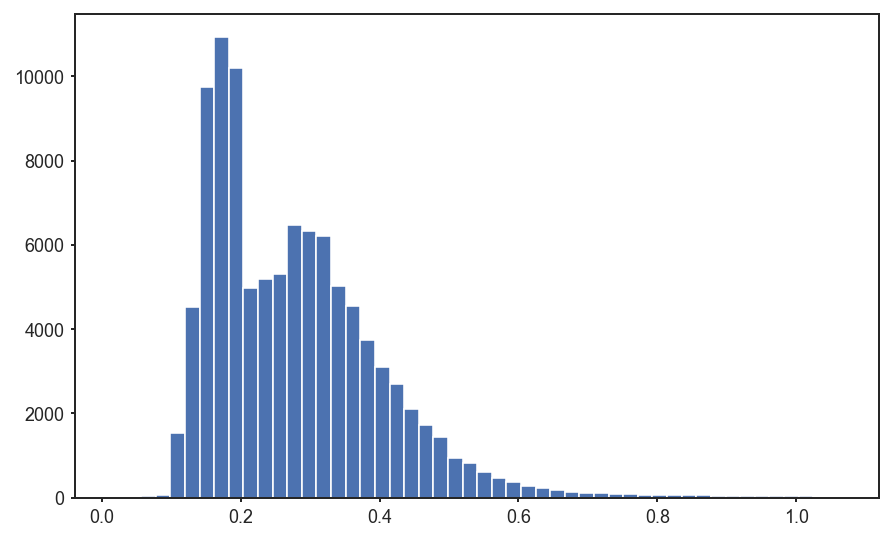

In [14]:
from loren_frank_data_processing import get_multiunit_dataframe

marks = get_multiunit_dataframe(("bon", 3, 2, 3), ANIMALS)

plt.hist(1000 * marks.max_width / 30_000, 50)

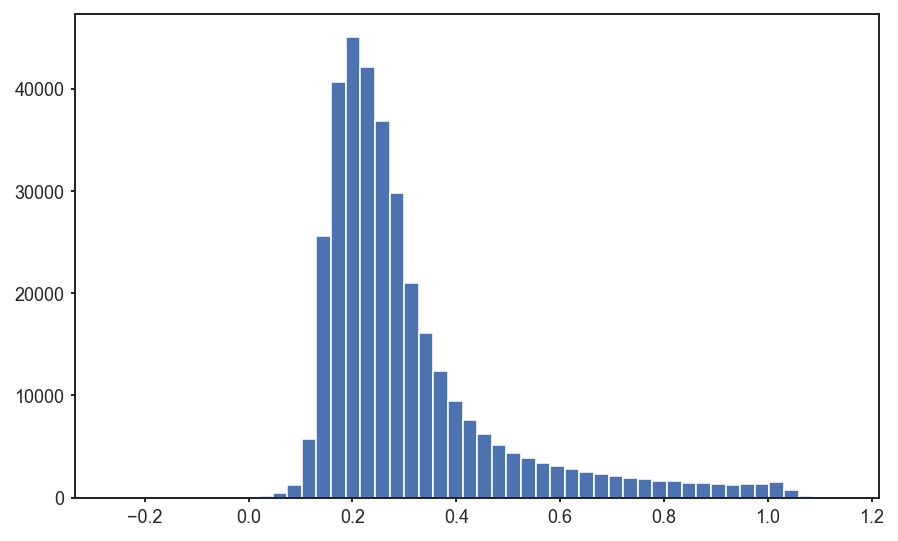

In [16]:
marks = get_multiunit_dataframe(("bon", 3, 2, 4), ANIMALS)

plt.hist(1000 * marks.max_width / 30_000, 50)

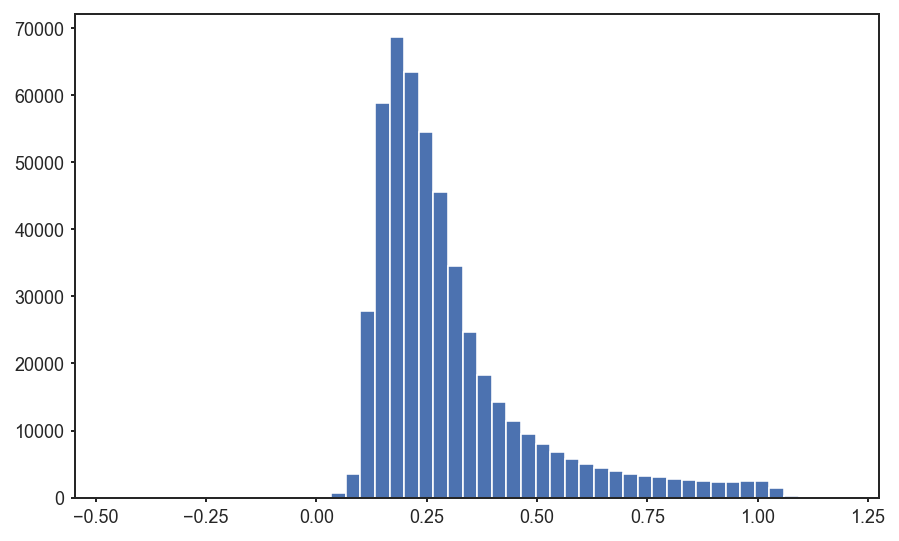

In [18]:
marks = get_multiunit_dataframe(("bon", 3, 2, 5), ANIMALS)

plt.hist(1000 * marks.max_width / 30_000, 50)